In [5]:
!pip install --user qctrl

  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
Processing /home/jovyan/.cache/pip/wheels/4d/08/ab/720b594423b2bac9f8f2d4d845725b909b73340e3ccda5d3cc/gql-3.0.0a4-py2.py3-none-any.whl
  Using cached cached_property-1.5.2-py2.py3-none-any.whl (7.6 kB)
  Using cached aiohttp-3.7.4.post0-cp37-cp37m-manylinux2014_x86_64.whl (1.3 MB)
  Using cached yarl-1.5.1-cp37-cp37m-manylinux1_x86_64.whl (258 kB)
  Using cached graphql_core-3.1.4-py3-none-any.whl (186 kB)
  Using cached multidict-5.1.0-cp37-cp37m-manylinux2014_x86_64.whl (142 kB)
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)


In [6]:
!pip install --user qctrl-visualizer qctrl-open-controls

  Using cached qctrl_open_controls-7.0.1-py3-none-any.whl (35 kB)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

#The Challenge

In [11]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

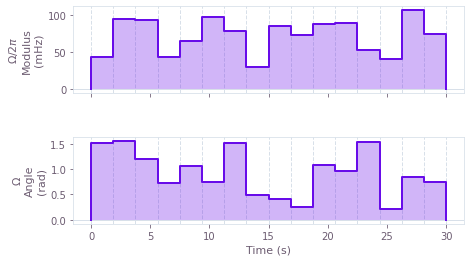

In [12]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [13]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

Your task calculate_qchack_measurements has completed in 3s.


#Band-Limited Pulses


In [18]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_y = np.array([[0, -1j], [1j, 0]])
ideal_not_gate = np.array([[0, 1], [1, 0]])
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
# Define physical constraints
alpha_max = 2 * np.pi * 8.5e6  # Hz
sinc_cutoff_frequency = 2 * np.pi * 48e6  # Hz
nu = 2 * np.pi * 6e6  # Hz
segment_count = 50
duration = 400e-9  # s

In [19]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

Your task calculate_qchack_measurements has completed in 3s.


In [24]:
def get_optimized_matrix(target_operator,repetitions=1,shots=1024):
  # 5. SPAM error confusion matrix
  confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

  with qctrl.create_graph() as graph:

      # Create initial alpha_1(t) signal
      alpha_1_values = qctrl.operations.bounded_optimization_variable(
          count=segment_count,
          lower_bound=-alpha_max,
          upper_bound=alpha_max,
      )
      alpha_1 = qctrl.operations.pwc_signal(
          values=alpha_1_values,
          duration=duration,
      )
      # Create filtered signal
      alpha_1_filtered = qctrl.operations.convolve_pwc(
          alpha_1,
          qctrl.operations.sinc_integral_function(sinc_cutoff_frequency),
      )
      # Discretize to obtain smoothed alpha_1(t) signal
      alpha_1 = qctrl.operations.discretize_stf(
          stf=alpha_1_filtered,
          duration=duration,
          segments_count=segment_count,
          name="alpha_1",
      )

      # Similarly, create alpha_2(t) signal
      alpha_2_values = qctrl.operations.bounded_optimization_variable(
          count=segment_count,
          lower_bound=-alpha_max,
          upper_bound=alpha_max,
      )
      alpha_2 = qctrl.operations.pwc_signal(
          values=alpha_2_values,
          duration=duration,
      )
      # Create filtered signal
      alpha_2_filtered = qctrl.operations.convolve_pwc(
          alpha_2,
          qctrl.operations.sinc_integral_function(sinc_cutoff_frequency),
      )
      # Discretize to obtain smoothed alpha_2(t) signal
      alpha_2 = qctrl.operations.discretize_stf(
          stf=alpha_2_filtered,
          duration=duration,
          segments_count=segment_count,
          name="alpha_2",
      )

      # Create drive term
      drive = qctrl.operations.pwc_operator_hermitian_part(
          qctrl.operations.pwc_operator(signal=alpha_1, operator=sigma_x / 2)
      )

      # Create clock shift term
      shift = qctrl.operations.pwc_operator(signal=alpha_2, operator=sigma_z / 2)

      # Create dephasing noise term
      dephasing = qctrl.operations.constant_pwc_operator(
          duration=duration, operator=sigma_z / duration
      )

      # Create target
      target_operator = qctrl.operations.target(operator=target_operator)


      #Construct Hamiltonian.
      hamiltonian = qctrl.operations.pwc_sum(
          [
          drive,
          shift,
          dephasing,
          ]
      )

      # Solve Schrodinger's equation and get total unitary at the end
      unitary = qctrl.operations.time_evolution_operators_pwc(
              hamiltonian=hamiltonian,
              sample_times=np.array([duration]),
          )[-1]
      unitary.name = "unitary"

      # Repeat final unitary
      repeated_unitary = np.eye(2)
      for _ in range(repetitions):
        repeated_unitary = repeated_unitary @ unitary
      repeated_unitary.name = "repeated_unitary"

      # Initial state
      initial_state = np.array([[1], [0]])

      # Calculate final state.
      state = repeated_unitary @ initial_state

      # Calculate final populations.
      populations = qctrl.operations.abs(state[:, 0]) ** 2
      # Normalize populations
      norm = qctrl.operations.sum(populations)
      populations = populations / norm
      populations.name = "populations"

      # Create infidelity
      infidelity = qctrl.operations.infidelity_pwc(
          hamiltonian=hamiltonian,
          target_operator=target_operator,
          noise_operators=[dephasing],
          name="infidelity",
      )

  # Run the optimization
  optimization_result = qctrl.functions.calculate_optimization(
      cost_node_name="infidelity",
      output_node_names=["alpha_1","alpha_2","unitary", "repeated_unitary", "populations"],
      graph=graph,
  )


  print("Optimized cost:\t", optimization_result.cost)

  # Plot the optimized controls
  plot_controls(
      plt.figure(),
      controls={
          "$\\alpha_1$": optimization_result.output["alpha_1"],
          "$\\alpha_2$": optimization_result.output["alpha_2"],
      },
  )
  plt.show()


  #Extract Outputs
  unitary = optimization_result.output["unitary"]["value"]
  populations = optimization_result.output["populations"]["value"]

  # Sample projective measurements.
  true_measurements = np.random.choice(2, size=shots, p=populations)
  measurements = np.array(
      [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
  )

  results = {"unitary": unitary, "measurements": measurements}
  return results

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 7s.
Optimized cost:	 3.3947097674842172e-12


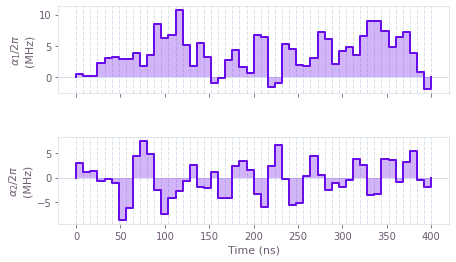

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 7s.
Optimized cost:	 3.772923692238505e-12


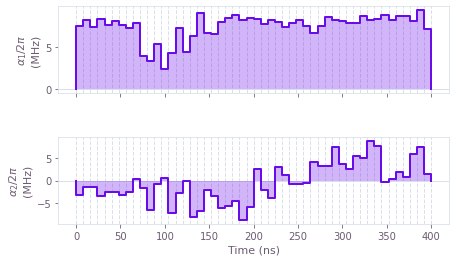

Realised NOT Gate:
[[ 1.57372352e-07+7.48396813e-07j -2.19069295e-07+1.00000000e+00j]
 [ 2.19069295e-07+1.00000000e+00j  1.57372352e-07-7.48396813e-07j]]
Ideal NOT Gate:
[[ 0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j]]
NOT Gate Error:6.326050794314142e-13
NOT estimated probability of getting 1:0.01171875
NOT estimate standard error:0.003363031570790017

Realised H Gate:
[[-7.07106912e-01+1.26485869e-07j -1.09871066e-06+7.07106650e-01j]
 [ 1.09871066e-06+7.07106650e-01j -7.07106912e-01-1.26485869e-07j]]
Ideal H Gate:
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
H Gate Error:1.2589929099249275e-12
H estimated probability of getting 1:0.013671875
H estimate standard error:0.003628898070360046


In [28]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)

not_op_matrix = get_optimized_matrix(ideal_not_gate,repetitions=100)
h_op_matrix = get_optimized_matrix(ideal_h_gate,repetitions=100)

realised_not_gate = not_op_matrix["unitary"]
ideal_not_gate = np.array([[0, -1j], [-1j, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_op_matrix["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_op_matrix["measurements"]
h_measurements = h_op_matrix["measurements"]
not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")

print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))
